In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
from arch import arch_model
from arch.univariate import ZeroMean,GARCH,Normal,EWMAVariance
import matplotlib.ticker as mtick
import warnings
import edhec_risk_kit_206 as erk
import seaborn as sns
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn')
#plt.style.reload_library()
#plt.style.use('science')
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import numpy as np
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

#### Data

In [294]:
SP_500=pd.read_excel("Data/S$P500.xlsx" ,index_col=0, parse_dates=True)
Campbell=pd.read_excel("Data/Campbell.xlsx" ,index_col=0, parse_dates=True)
Apple=pd.read_excel("Data/Apple.xlsx" ,index_col=0, parse_dates=True)
Econ=pd.read_excel("Data/Economic Data.xlsx" ,index_col=0, parse_dates=True)

#### Visualizing Data

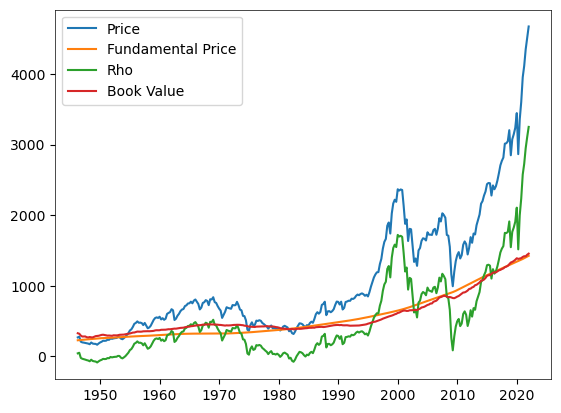

In [204]:
plt.plot(SP_500[['Price','Fundamental Price','Rho','Book Value']])
plt.legend(['Price','Fundamental Price','Rho','Book Value'])
plt.show()

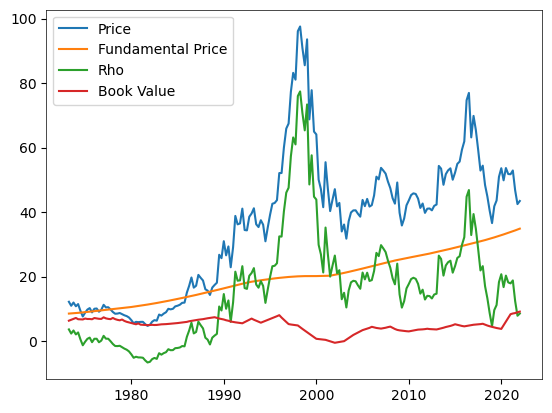

In [205]:
plt.plot(Campbell[['Price','Fundamental Price','Rho','Book Value']])
plt.legend(['Price','Fundamental Price','Rho','Book Value'])
plt.show()

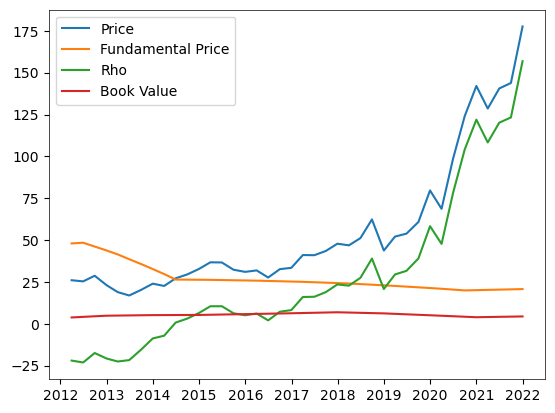

In [206]:
plt.plot(Apple[['Price','Fundamental Price','Rho','Book Value']])
plt.legend(['Price','Fundamental Price','Rho','Book Value'])
plt.show()

## S&P Variance Decomposition

#### Variables construction

In [295]:
SP_500_Shiller=pd.DataFrame(index=SP_500.index)
SP_500_Shiller['Log return']=np.log(1+SP_500['Return'])
SP_500_Shiller['Delta']=np.log(SP_500['Dividend'])-np.log(SP_500['Price'])
SP_500_Shiller['Delta_*']=np.log(SP_500['Dividend'])-np.log(SP_500['Fundamental Price'])
SP_500_Shiller['Delta Dividend']=np.log(SP_500['Dividend'])-np.log(SP_500['Dividend']).shift(1)
z=np.mean(1+(SP_500['Rho']/SP_500['Dividend']))
SP_500_Shiller['Beta']=np.log(z)+(1/z)*((1+(SP_500['Rho']/SP_500['Dividend']))-z)

In [296]:
lambda_ = 1/(1+np.exp(np.mean(SP_500_Shiller['Beta']+np.log(SP_500['Dividend'])-np.log(SP_500['Fundamental Price']))))
SP_500_Shiller['Delta_*'] = lambda_*SP_500_Shiller['Delta_*']
SP_500_Shiller['Beta'] = (1-lambda_)*SP_500_Shiller['Beta']
SP_500_Shiller['Delta'] = (1-lambda_)*SP_500_Shiller['Delta'].shift(1)
SP_500_Shiller.dropna(inplace=True)
lambda_

0.552918652534287

In [297]:
SP_500_Vuolteenaho=pd.DataFrame(index=SP_500.index)
SP_500_Vuolteenaho['Log return']=np.log(1+SP_500['Return'])
SP_500_Vuolteenaho['Log ROE']=np.log(1+SP_500['ROE'])
SP_500_Vuolteenaho['Log Rf']=np.log(1+Econ.loc[SP_500.index,'Real Interest Rate']/4)
SP_500_Vuolteenaho['Log Excess Ret']=SP_500_Vuolteenaho['Log return']-SP_500_Vuolteenaho['Log Rf']
SP_500_Vuolteenaho['Theta']=np.log(SP_500['Book Value'])-np.log(SP_500['Price'])
SP_500_Vuolteenaho['Theta_*']=np.log(SP_500['Book Value'])-np.log(SP_500['Fundamental Price'])
SP_500_Vuolteenaho['Alpha']=np.log(1+(SP_500['Rho']/SP_500['Fundamental Price']))
SP_500_Vuolteenaho['Gamma']=np.log(SP_500['Dividend'])-np.log(SP_500['Book Value'])
SP_500_Vuolteenaho['Delta']=np.log(SP_500['Dividend'])-np.log(SP_500['Price'])
SP_500_Vuolteenaho['Delta_*']=np.log(SP_500['Dividend'])-np.log(SP_500['Fundamental Price'])

In [298]:
w=0.7
phi=w*np.mean(SP_500_Vuolteenaho['Gamma'])+(1-w)*np.mean(SP_500_Vuolteenaho['Delta'])
etha = np.exp(-phi)/(1+np.mean(np.exp(-phi)))
SP_500_Vuolteenaho['Theta_*'] = etha*SP_500_Vuolteenaho['Theta_*']
SP_500_Vuolteenaho['Alpha'] = etha*SP_500_Vuolteenaho['Alpha']
SP_500_Vuolteenaho['Theta'] = SP_500_Vuolteenaho['Theta'].shift(1)
SP_500_Vuolteenaho.dropna(inplace=True)
etha

0.9899390942519379

#### Rolling Variance Covariance Decomposition S&P 500

In [299]:
varcov_SP = SP_500_Shiller.rolling(20).cov()

In [300]:
ind = SP_500_Shiller.index
ratio_SP_sh = pd.DataFrame(index=ind,columns=['Est Var','Est Esp Var','Ratio'])

for i in range(0,len(ind)):
    y=varcov_SP.loc[ind[i],:].copy()
    a=y.iloc[1,1]+y.iloc[2,2]+y.iloc[3,3]+y.iloc[4,4]+2*(-y.iloc[1,2]+y.iloc[1,3]+y.iloc[1,4]-y.iloc[2,3]-y.iloc[2,4]+y.iloc[3,4])
    b=y.iloc[4,4]
    #b=2*(y.iloc[1,4]-y.iloc[2,4]+y.iloc[3,4])+y.iloc[4,4]
    ratio_SP_sh.iloc[i,0]=a
    ratio_SP_sh.iloc[i,1]=b
    ratio_SP_sh.iloc[i,2]=b/a

In [301]:
varcov_SP_V = SP_500_Vuolteenaho.rolling(20).cov()

In [302]:
ind_2 = SP_500_Vuolteenaho.index
ratio_SP_V = pd.DataFrame(index=ind_2,columns=['Est Var','Est Esp Var','Ratio'])

for i in range(0,len(ind_2)):
    y=varcov_SP_V.loc[ind_2[i],:].copy()
    a=y.iloc[1,1]+y.iloc[2,2]+y.iloc[4,4]+y.iloc[5,5]+y.iloc[6,6]+2*(-y.iloc[1,2]-y.iloc[1,5]+y.iloc[1,4]+y.iloc[1,6]+y.iloc[2,5]-y.iloc[2,4]-y.iloc[2,6]-y.iloc[5,4]-y.iloc[5,6]+y.iloc[4,6])
    # b = y.iloc[6,6]
    b =2*(y.iloc[1,6]-y.iloc[2,6]+y.iloc[4,6]-y.iloc[5,6])+y.iloc[6,6]
    ratio_SP_V.iloc[i,0]=a
    ratio_SP_V.iloc[i,1]=b
    ratio_SP_V.iloc[i,2]=b/a

VAR Analysis

In [303]:
SP_500_Shiller['Delta_*'] = SP_500_Shiller['Delta_*']/lambda_
SP_500_Shiller['Beta'] = SP_500_Shiller['Beta']/(1-lambda_)
SP_500_Shiller['Delta'] = SP_500_Shiller['Delta']/(1-lambda_)

In [304]:
SP_VAR_sh = pd.DataFrame(index=SP_500_Shiller.index, columns=['ret','ret_lag','dd','dd_lag','beta','beta_lag'])
SP_VAR_sh['ret'] = SP_500_Shiller['Log return']-np.mean(SP_500_Shiller['Log return'])
SP_VAR_sh['ret_lag'] = SP_VAR_sh['ret'].shift(1)
SP_VAR_sh['dd'] = (SP_500_Shiller['Delta Dividend']-np.mean((SP_500_Shiller['Delta Dividend']))).shift(1)
SP_VAR_sh['dd_lag'] = SP_VAR_sh['dd'].shift(1)
SP_VAR_sh['beta'] = (SP_500_Shiller['Beta']-np.mean(SP_500_Shiller['Beta'])).shift(1)
SP_VAR_sh['beta_lag'] = SP_VAR_sh['beta'].shift(1)
SP_VAR_sh.dropna(inplace=True)
SP_VAR_sh.to_csv("S&P_VAR_sh_input.csv")

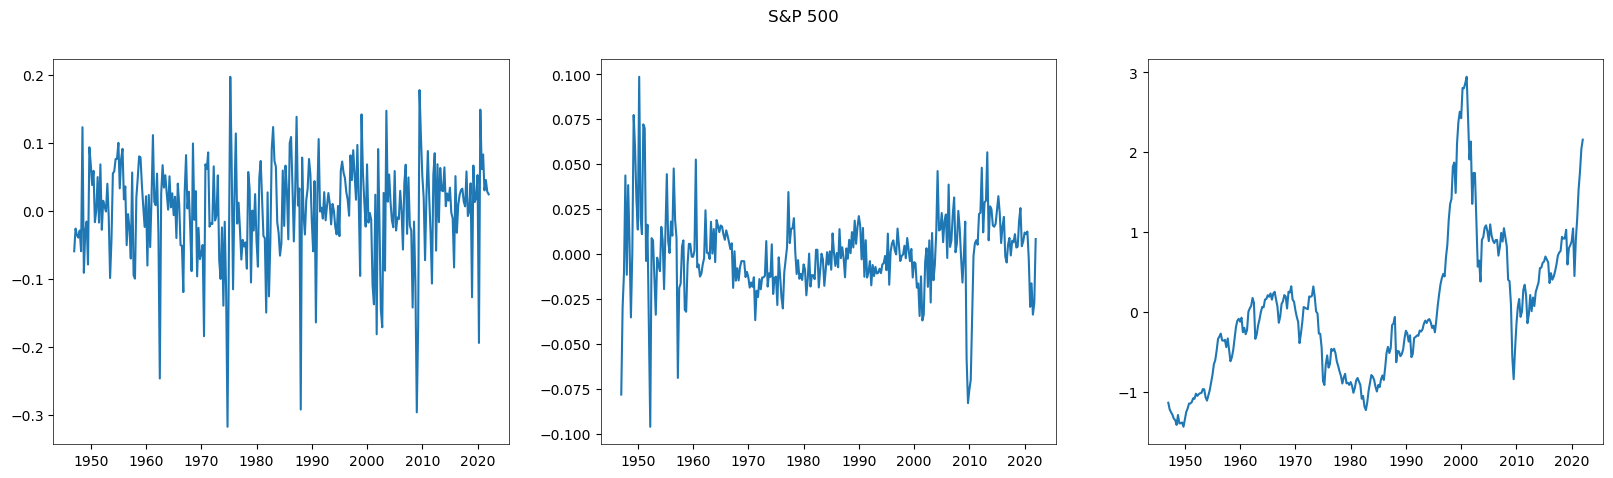

In [218]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('S&P 500')
ax1.plot(SP_VAR_sh.index,SP_VAR_sh['ret'])
ax2.plot(SP_VAR_sh.index,SP_VAR_sh['dd'])
ax3.plot(SP_VAR_sh.index,SP_VAR_sh['beta'])
plt.show()

In [141]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(SP_VAR_sh, variables = SP_VAR_sh.columns[[0,2,4]])  

,ret_x,dd_x,beta_x
ret_y,1.0000,0.3586,0.1156
dd_y,0.0004,1.0000,0.0006
beta_y,0.0000,0.4444,1.0000


In [142]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(SP_VAR_sh.loc[:,SP_VAR_sh.columns[[0,2,4]]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ret    ::  84.8      > 24.2761   =>   True
dd     ::  25.56     > 12.3212   =>   True
beta   ::  2.69      > 4.1296    =>   False


In [143]:

from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  


In [62]:
for name, column in SP_VAR_sh.loc[:,SP_VAR_sh.columns[[0,2,4]]].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ret" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.3698
 No. Lags Chosen       = 0
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dd" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8678
 No. Lags Chosen       = 7
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "beta" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

In [63]:
model_sp = VAR(SP_VAR_sh.iloc[:,])
x = model_sp.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-31.76,-31.68,1.611e-14,-31.73
1,-239.9*,-239.4*,6.597e-105*,-239.7*
2,-231.5,-230.5,2.795e-101,-231.1
3,-235.1,-233.6,8.192e-103,-234.5
4,-235.4,-233.5,5.782e-103,-234.7
5,-230.0,-227.6,1.340e-100,-229.0
6,-227.2,-224.4,2.200e-99,-226.0
7,-227.5,-224.2,1.639e-99,-226.2
8,-227.1,-223.4,2.302e-99,-225.6
9,-226.8,-222.6,3.301e-99,-225.1


In [305]:
model_sp = VAR(SP_VAR_sh.iloc[:,[0,2,4]])
results_sp = model_sp.fit(2)
results_sp.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Jun, 2022
Time:                     16:53:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -18.0521
Nobs:                     299.000    HQIC:                  -18.2080
Log likelihood:           1485.85    FPE:                1.11485e-08
AIC:                     -18.3120    Det(Omega_mle):     1.04008e-08
--------------------------------------------------------------------
Results for equation ret
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000132         0.004250            0.031           0.975
L1.ret          0.112218         0.058378            1.922           0.055
L1.dd           0.090715         0.223748            0.405           0.685
L1.beta    

In [306]:
A_sp_h=np.linalg.cholesky(results_sp.resid_acov(0)[0])
H_sp_h=np.dot(np.linalg.inv(A_sp_h),results_sp.resid_acov(0)[0])
J=np.zeros((3,6))
J[0][0]=1
J[1][2]=1
J[2][4]=1
coefs_SP_sh=np.zeros((6,6))
for i in range(3):
    s=0
    for k in range(3):
        for j in range (2):
            coefs_SP_sh[2*i][s]= results_sp.coefs[j][i][k]
            s=s+1
coefs_SP_sh[1][0]=1
coefs_SP_sh[3][2]=1
coefs_SP_sh[5][4]=1

In [307]:
e_1=pd.array([1,0,0,0,0,0])
e_2=pd.array([0,0,1,0,0,0])
e_3=pd.array([0,0,0,0,1,0])
e_4=pd.array([-1,0,1,0,1,0])
iden=np.identity(6)
e_lambda_1=np.dot(np.dot(np.dot(np.dot(e_1,lambda_*coefs_SP_sh),np.linalg.inv(iden-lambda_*coefs_SP_sh)),J.T),A_sp_h)
e_lambda_2=np.dot(np.dot(np.dot(np.dot(e_2,lambda_*coefs_SP_sh),np.linalg.inv(iden-lambda_*coefs_SP_sh)),J.T),A_sp_h)
e_lambda_3=np.dot(np.dot(np.dot(np.dot(e_3,(1-lambda_)*lambda_*coefs_SP_sh),np.linalg.inv(iden-lambda_*coefs_SP_sh)),J.T),A_sp_h)

In [308]:
Vol_SP=np.dot(e_lambda_2+e_lambda_3-e_lambda_1,(e_lambda_2+e_lambda_3-e_lambda_1).T)
Vol_SP_nf=np.dot(e_lambda_3,(e_lambda_3).T)
uncond_ratio_SP=Vol_SP_nf/Vol_SP
uncond_ratio_SP

1.0959609638695067

#### Vuolteenaho VAR decomposition

In [309]:
SP_500_Vuolteenaho['Theta_*'] = SP_500_Vuolteenaho['Theta_*']/etha
SP_500_Vuolteenaho['Alpha'] = SP_500_Vuolteenaho['Alpha']/etha

In [310]:
SP_VAR_v = pd.DataFrame(index=SP_500_Vuolteenaho.index, columns=['ret','ret_lag','ex_roe','ex_roe_lag','alpha','alpha_lag'])
SP_VAR_v['ret'] = SP_500_Vuolteenaho['Log return']-np.mean(SP_500_Vuolteenaho['Log return'])
SP_VAR_v['ret_lag'] = SP_VAR_v['ret'].shift(1)
SP_VAR_v['ex_roe'] = ((SP_500_Vuolteenaho['Log ROE']-SP_500_Vuolteenaho['Log Rf'])-np.mean((SP_500_Vuolteenaho['Log ROE']-SP_500_Vuolteenaho['Log Rf']))).shift(1)
SP_VAR_v['ex_roe_lag'] = SP_VAR_v['ex_roe'].shift(1)
SP_VAR_v['alpha'] = (SP_500_Vuolteenaho['Alpha']-np.mean(SP_500_Vuolteenaho['Alpha'])).shift(1)
SP_VAR_v['alpha_lag'] = SP_VAR_v['alpha'].shift(1)
SP_VAR_v.dropna(inplace=True)
SP_VAR_v.to_csv("S&P_VAR_v_input.csv")

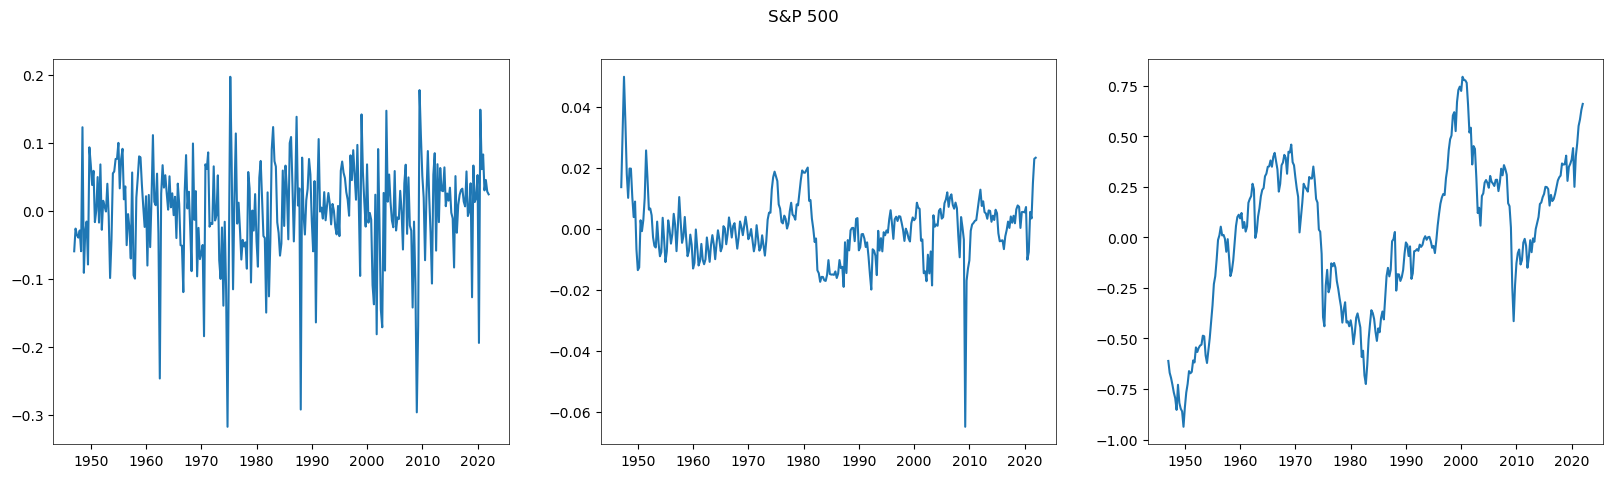

In [150]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('S&P 500')
ax1.plot(SP_VAR_v.index,SP_VAR_v['ret'])
ax2.plot(SP_VAR_v.index,SP_VAR_v['ex_roe'])
ax3.plot(SP_VAR_v.index,SP_VAR_v['alpha'])
plt.show()

In [151]:
grangers_causation_matrix(SP_VAR_v, variables = SP_VAR_v.columns[[0,2,4]])  

,ret_x,ex_roe_x,alpha_x
ret_y,1.0000,0.0195,0.0557
ex_roe_y,0.0145,1.0000,0.0933
alpha_y,0.0000,0.0208,1.0000


In [152]:
cointegration_test(SP_VAR_v.loc[:,SP_VAR_v.columns[[0,2,4]]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ret    ::  38.32     > 24.2761   =>   True
ex_roe ::  9.82      > 12.3212   =>   False
alpha  ::  2.43      > 4.1296    =>   False


In [153]:
for name, column in SP_VAR_v.loc[:,SP_VAR_v.columns[[0,2,4]]].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ret" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.3698
 No. Lags Chosen       = 0
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ex_roe" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5633
 No. Lags Chosen       = 12
 Critical value 1%     = -3.453
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0065. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "alpha" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

In [154]:
model_sp_v = VAR(SP_VAR_v.iloc[:,:])
x = model_sp_v.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-43.83,-43.75,9.256e-20,-43.80
1,-258.6*,-258.1*,4.679e-113*,-258.4*
2,-245.3,-244.3,2.842e-107,-244.9
3,-251.6,-250.2,5.366e-110,-251.0
4,-248.2,-246.3,1.545e-108,-247.5
5,-245.9,-243.6,1.587e-107,-245.0
6,-245.6,-242.8,2.212e-107,-244.5
7,-244.5,-241.2,6.640e-107,-243.2
8,-245.2,-241.5,3.196e-107,-243.7
9,-243.9,-239.8,1.171e-106,-242.3


In [311]:
model_sp_v = VAR(SP_VAR_v.iloc[:,[0,2,4]])
results_sp_v = model_sp_v.fit(2)
results_sp_v.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Jun, 2022
Time:                     16:53:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -31.4284
Nobs:                     299.000    HQIC:                  -31.5843
Log likelihood:           3485.62    FPE:                1.72958e-14
AIC:                     -31.6883    Det(Omega_mle):     1.61358e-14
--------------------------------------------------------------------
Results for equation ret
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.006523         0.006588            0.990           0.322
L1.ret            0.092138         0.058647            1.571           0.116
L1.ex_roe        -1.122350         0.620243           -1.810           0.070
L

In [312]:
A_sp_v=np.linalg.cholesky(results_sp_v.resid_acov(0)[0])
H_sp_v=np.dot(np.linalg.inv(A_sp_v),results_sp_v.resid_acov(0)[0])
J=np.zeros((3,6))
J[0][0]=1
J[1][2]=1
J[2][4]=1
coefs_SP_v=np.zeros((6,6))
for i in range(3):
    s=0
    for k in range(3):
        for j in range (2):
            coefs_SP_v[2*i][s]= results_sp_v.coefs[j][i][k]
            s=s+1
coefs_SP_v[1][0]=1
coefs_SP_v[3][2]=1
coefs_SP_v[5][4]=1

In [353]:
e_1=pd.array([1,0,0,0,0,0])
e_2=pd.array([0,0,1,0,0,0])
e_3=pd.array([0,0,0,0,1,0])
e_4=pd.array([-1,0,1,0,1,0])
iden=np.identity(6)
e_etha_1=np.dot(np.dot(np.dot(np.dot(e_1,etha*coefs_SP_v),np.linalg.inv(iden-etha*coefs_SP_v)),J.T),A_sp_v)
e_etha_2=np.dot(np.dot(np.dot(np.dot(e_2,coefs_SP_v),np.linalg.inv(iden-etha*coefs_SP_v)),J.T),A_sp_v)
e_etha_3=np.dot(np.dot(np.dot(np.dot(e_3,(etha**2)*coefs_SP_v),np.linalg.inv(iden-etha*coefs_SP_v)),J.T),A_sp_v)

In [354]:
Vol_SP_V=np.dot(e_etha_2+e_etha_3-e_etha_1,(e_etha_2+e_etha_3-e_etha_1).T)
Vol_SP_nf_V=np.dot(e_etha_3,(e_etha_3).T)
uncond_ratio_SP_V=Vol_SP_nf_V/Vol_SP_V
uncond_ratio_SP_V

0.9663522031812066

#### Graphs

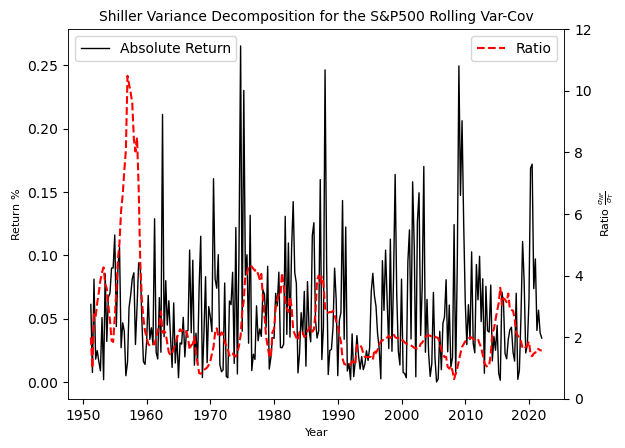

In [469]:
#sns.set_style("whitegrid", {'axes.linewidth':10, 'axes.edgecolor':'black'})
plt.rcParams.update(plt.rcParamsDefault)
import matplotlib
matplotlib.rcParams['axes.linewidth']=0.5
ratio_SP_sh['Return']=SP_500.loc[:,'Return']
ratio_SP_sh['Return_abs']=np.abs(ratio_SP_sh['Return'])
ratio_SP_sh.dropna(inplace=True)
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(ratio_SP_sh['Return_abs'], color="black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper left')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(ratio_SP_sh['Ratio'],'--',color="red", linewidth=1.5, label= 'Ratio' )
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
ax2.set_ybound(12)
ax2.set_ylim(0.0)
plt.legend()
plt.title('Shiller Variance Decomposition for the S&P500 Rolling Var-Cov', fontsize=10)
plt.show()
#start after 55

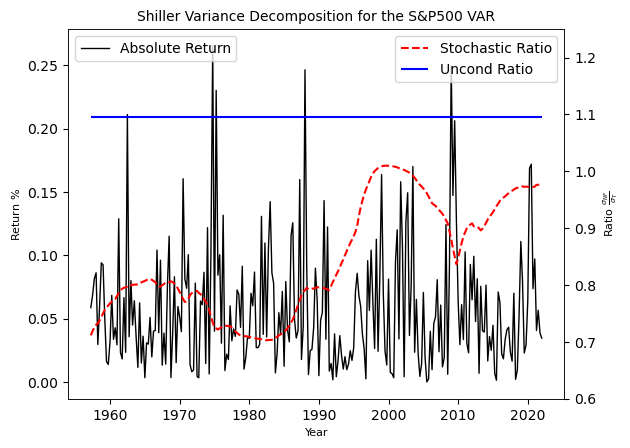

In [468]:
#sns.set_style("whitegrid", {'axes.linewidth':10, 'axes.edgecolor':'black'})
svr_sp_sh = pd.read_csv("ratio_sp_sh_Sv.csv",index_col=0)
svr_sp_sh=svr_sp_sh.T
l1=len(svr_sp_sh)
l2=len(SP_500['Return'])
SP_sv_df = pd.DataFrame((np.abs(SP_500['Return'])).iloc[l2-l1:])
SP_sv_df.columns=['Return_abs']
svr_sp_sh.index=SP_sv_df.index
SP_sv_df['Ratio']=svr_sp_sh
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(SP_sv_df['Return_abs'], color="Black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper left')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(SP_sv_df['Ratio'],'--',color="red", linewidth=1.5, label= 'Stochastic Ratio' )
ax2.hlines(uncond_ratio_SP,SP_sv_df.index[0],SP_sv_df.index[-1], linewidth=1.5, label= 'Uncond Ratio' , color="Blue")
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
ax2.set_ybound(1.25)
ax2.set_ylim(0.6)
plt.legend()
plt.title('Shiller Variance Decomposition for the S&P500 VAR', fontsize=10)
plt.show()

In [83]:
z=pd.DataFrame(np.cov(SP_sv_df.loc[:,['Ratio','Return']].T.astype(float)))
z.iloc[0,1]/((z.iloc[0,0]**(1/2))*(z.iloc[1,1]**(1/2)))

-0.0421708211331334

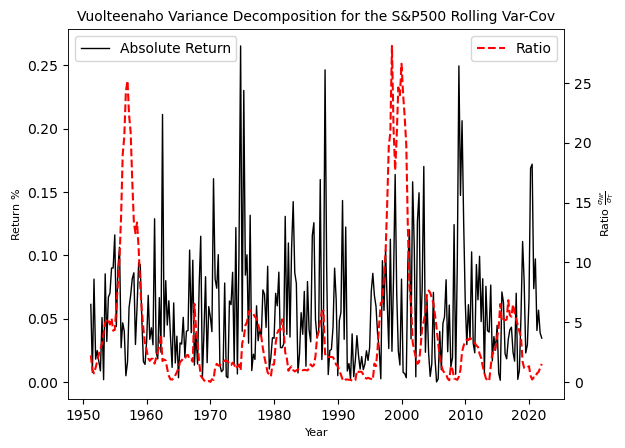

In [317]:
ratio_SP_V['Return']=SP_500.loc[:,'Return']
ratio_SP_V['Return_abs']=np.abs(ratio_SP_V['Return'])
ratio_SP_V.dropna(inplace=True)
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(ratio_SP_V['Return_abs'], color="black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper left')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(np.abs(ratio_SP_V['Ratio']),'--',color="red", linewidth=1.5, label= 'Ratio' )
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
plt.legend()
plt.title('Vuolteenaho Variance Decomposition for the S&P500 Rolling Var-Cov', fontsize=10)
plt.show()

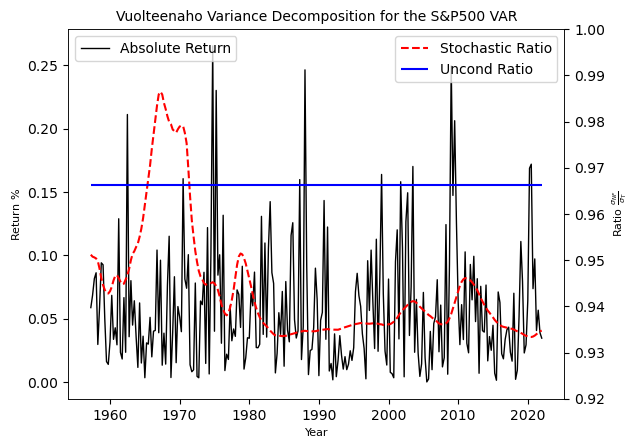

In [472]:
#sns.set_style("whitegrid", {'axes.linewidth':10, 'axes.edgecolor':'black'})
svr_sp_vv = pd.read_csv("ratio_sp_v_Sv.csv",index_col=0)
svr_sp_vv=svr_sp_vv.T
l1=len(svr_sp_vv)
l2=len(SP_500['Return'])
SP_sv_df_v = pd.DataFrame((np.abs(SP_500['Return'])).iloc[l2-l1:])
SP_sv_df_v.columns=['Return_abs']
svr_sp_vv.index=SP_sv_df_v.index
SP_sv_df_v['Ratio']=svr_sp_vv
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(SP_sv_df_v['Return_abs'], color="Black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper left')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(SP_sv_df_v['Ratio'],'--',color="red", linewidth=1.5, label= 'Stochastic Ratio' )
ax2.hlines(uncond_ratio_SP_V,SP_sv_df_v.index[0],SP_sv_df_v.index[-1], linewidth=1.5, label= 'Uncond Ratio' , color="Blue")
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
ax2.set_ybound(1.0)
ax2.set_ylim(0.92)
plt.legend()
plt.title('Vuolteenaho Variance Decomposition for the S&P500 VAR', fontsize=10)
plt.show()

In [1088]:
z=pd.DataFrame(np.cov(SP_v_sv_df.loc[:,['Ratio','Return']].T.astype(float)))
z.iloc[0,1]/((z.iloc[0,0]**(1/2))*(z.iloc[1,1]**(1/2)))

0.1125832893626711

## Campbell Variance Decomposition

#### Variables construction

In [381]:
C_500_Shiller=pd.DataFrame(index=Campbell.index)
C_500_Shiller['Log return']=np.log(1+Campbell['Return'])
C_500_Shiller['Delta']=np.log(Campbell['Dividend'])-np.log(Campbell['Price'])
C_500_Shiller['Delta_*']=np.log(Campbell['Dividend'])-np.log(Campbell['Fundamental Price'])
C_500_Shiller['Delta Dividend']=np.log(Campbell['Dividend'])-np.log(Campbell['Dividend']).shift(1)
z=np.mean(1+(Campbell['Rho']/Campbell['Dividend']))
C_500_Shiller['Beta']=np.log(z)+(1/z)*((1+(Campbell['Rho']/Campbell['Dividend']))-z)

In [382]:
lambda_C = 1/(1+np.exp(np.mean(C_500_Shiller['Beta']+np.log(Campbell['Dividend'])-np.log(Campbell['Fundamental Price']))))
C_500_Shiller['Delta_*'] = lambda_C*C_500_Shiller['Delta_*']
C_500_Shiller['Beta'] = (1-lambda_C)*C_500_Shiller['Beta']
C_500_Shiller['Delta'] = (1-lambda_C)*C_500_Shiller['Delta'].shift(1)
C_500_Shiller.dropna(inplace=True)
lambda_C

0.6288756759141668

In [383]:
C_500_Vuolteenaho=pd.DataFrame(index=Campbell.index)
C_500_Vuolteenaho['Log return']=np.log(1+Campbell['Return'])
C_500_Vuolteenaho['Log ROE']=np.log(1+Campbell['ROE'])
C_500_Vuolteenaho['Log Rf']=np.log(1+Econ.loc[Campbell.index,'Real Interest Rate']/4)
C_500_Vuolteenaho['Log Excess Ret']=C_500_Vuolteenaho['Log return']-C_500_Vuolteenaho['Log Rf']
C_500_Vuolteenaho['Theta']=np.log(Campbell['Book Value'])-np.log(Campbell['Price'])
C_500_Vuolteenaho['Theta_*']=np.log(Campbell['Book Value'])-np.log(Campbell['Fundamental Price'])
C_500_Vuolteenaho['Alpha']=np.log(1+(Campbell['Rho']/Campbell['Fundamental Price']))
C_500_Vuolteenaho['Gamma']=np.log(Campbell['Dividend'])-np.log(Campbell['Book Value'])
C_500_Vuolteenaho['Delta']=np.log(Campbell['Dividend'])-np.log(Campbell['Price'])
C_500_Vuolteenaho['Delta_*']=np.log(Campbell['Dividend'])-np.log(Campbell['Fundamental Price'])

In [384]:
w=0.7
phi_C=w*np.mean(C_500_Vuolteenaho['Gamma'])+(1-w)*np.mean(C_500_Vuolteenaho['Delta'])
etha_C = np.exp(-phi_C)/(1+np.mean(np.exp(-phi_C)))
C_500_Vuolteenaho['Theta_*'] = etha_C*C_500_Vuolteenaho['Theta_*']
C_500_Vuolteenaho['Alpha'] = etha_C*C_500_Vuolteenaho['Alpha']
C_500_Vuolteenaho['Theta'] = C_500_Vuolteenaho['Theta'].shift(1)
C_500_Vuolteenaho.dropna(inplace=True)
etha_C

0.9743784388090333

#### Rolling Variance Covariance Decomposition Campbell

In [385]:
varcov_C = C_500_Shiller.rolling(20).cov()

In [386]:
ind = C_500_Shiller.index
ratio_C_sh = pd.DataFrame(index=ind,columns=['Est Var','Est Esp Var','Ratio'])

for i in range(0,len(ind)):
    y=varcov_C.loc[ind[i],:].copy()
    a=y.iloc[1,1]+y.iloc[2,2]+y.iloc[3,3]+y.iloc[4,4]+2*(-y.iloc[1,2]+y.iloc[1,3]+y.iloc[1,4]-y.iloc[2,3]-y.iloc[2,4]+y.iloc[3,4])
    b=y.iloc[4,4]
    #b=2*(y.iloc[1,4]-y.iloc[2,4]+y.iloc[3,4])+y.iloc[4,4]
    ratio_C_sh.iloc[i,0]=a
    ratio_C_sh.iloc[i,1]=b
    ratio_C_sh.iloc[i,2]=b/a

In [387]:
varcov_C_V = C_500_Vuolteenaho.rolling(20).cov()

In [388]:
ind_2 = C_500_Vuolteenaho.index
ratio_C_V = pd.DataFrame(index=ind_2,columns=['Est Var','Est Esp Var','Ratio'])

for i in range(0,len(ind_2)):
    y=varcov_SP_V.loc[ind_2[i],:].copy()
    a=y.iloc[1,1]+y.iloc[2,2]+y.iloc[4,4]+y.iloc[5,5]+y.iloc[6,6]+2*(-y.iloc[1,2]-y.iloc[1,5]+y.iloc[1,4]+y.iloc[1,6]+y.iloc[2,5]-y.iloc[2,4]-y.iloc[2,6]-y.iloc[5,4]-y.iloc[5,6]+y.iloc[4,6])
    # b = y.iloc[6,6]
    b =2*(y.iloc[1,6]-y.iloc[2,6]+y.iloc[4,6]-y.iloc[5,6])+y.iloc[6,6]
    ratio_C_V.iloc[i,0]=a
    ratio_C_V.iloc[i,1]=b
    ratio_C_V.iloc[i,2]=b/a

VAR Analysis

In [389]:
C_500_Shiller['Delta_*'] = C_500_Shiller['Delta_*']/lambda_C
C_500_Shiller['Beta'] = C_500_Shiller['Beta']/(1-lambda_C)
C_500_Shiller['Delta'] = C_500_Shiller['Delta']/(1-lambda_C)

In [390]:
C_VAR_sh = pd.DataFrame(index=C_500_Shiller.index, columns=['ret','ret_lag','dd','dd_lag','beta','beta_lag'])
C_VAR_sh['ret'] = C_500_Shiller['Log return']-np.mean(C_500_Shiller['Log return'])
C_VAR_sh['ret_lag'] = C_VAR_sh['ret'].shift(1)
C_VAR_sh['dd'] = (C_500_Shiller['Delta Dividend']-np.mean((C_500_Shiller['Delta Dividend']))).shift(1)
C_VAR_sh['dd_lag'] = C_VAR_sh['dd'].shift(1)
C_VAR_sh['beta'] = (C_500_Shiller['Beta']-np.mean(C_500_Shiller['Beta'])).shift(1)
C_VAR_sh['beta_lag'] = C_VAR_sh['beta'].shift(1)
C_VAR_sh.dropna(inplace=True)
C_VAR_sh.to_csv("C_VAR_sh_input.csv")

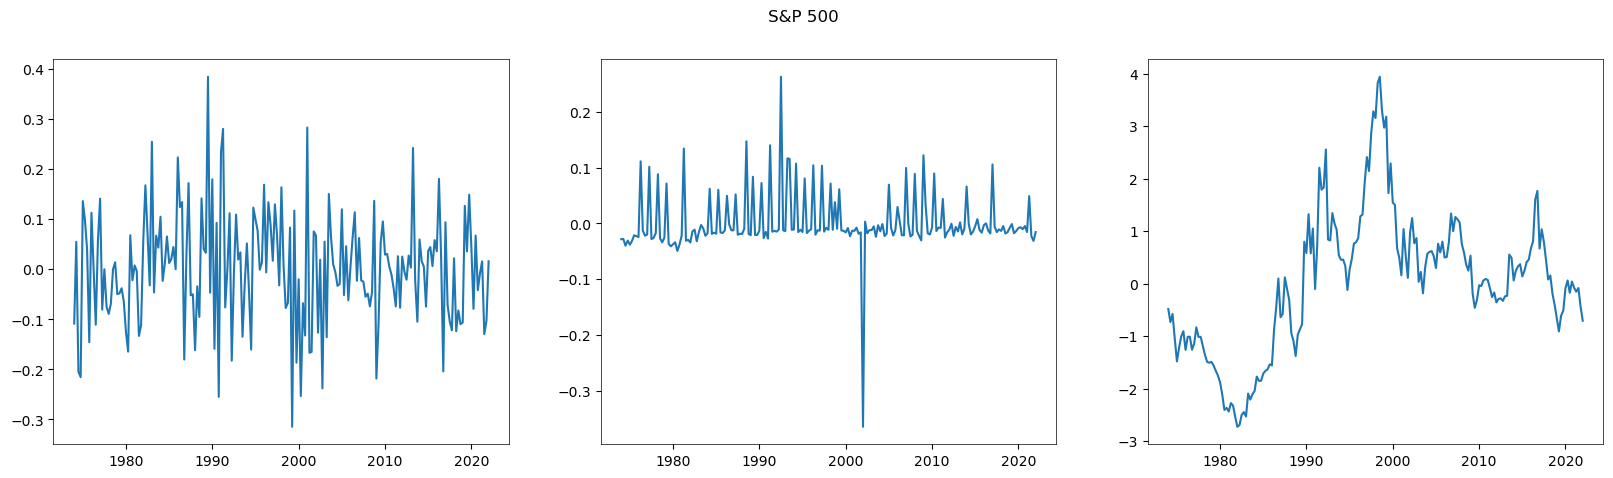

In [330]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('S&P 500')
ax1.plot(C_VAR_sh.index,C_VAR_sh['ret'])
ax2.plot(C_VAR_sh.index,C_VAR_sh['dd'])
ax3.plot(C_VAR_sh.index,C_VAR_sh['beta'])
plt.show()

In [331]:
grangers_causation_matrix(C_VAR_sh, variables = C_VAR_sh.columns[[0,2,4]])  

,ret_x,dd_x,beta_x
ret_y,1.0,0.0246,0.0093
dd_y,0.0,1.0000,0.0000
beta_y,0.0,0.0333,1.0000


In [332]:
cointegration_test(C_VAR_sh.loc[:,C_VAR_sh.columns[[0,2,4]]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ret    ::  61.92     > 24.2761   =>   True
dd     ::  25.63     > 12.3212   =>   True
beta   ::  4.53      > 4.1296    =>   True


In [333]:
for name, column in C_VAR_sh.loc[:,C_VAR_sh.columns[[0,2,4]]].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ret" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.9995
 No. Lags Chosen       = 0
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dd" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.3549
 No. Lags Chosen       = 4
 Critical value 1%     = -3.466
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "beta" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [334]:
model_C = VAR(C_VAR_sh.iloc[:,])
x = model_C.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-24.19,-24.08,3.127e-11,-24.15
1,-236.1*,-235.3*,2.938e-103*,-235.8*
2,-229.1,-227.8,3.094e-100,-228.6
3,-224.4,-222.4,3.500e-98,-223.6
4,-222.1,-219.5,3.362e-97,-221.1
5,-222.8,-219.5,1.776e-97,-221.5
6,-220.1,-216.2,2.584e-96,-218.5
7,-217.5,-213.0,3.522e-95,-215.7
8,-214.0,-208.8,1.209e-93,-211.9
9,-215.3,-209.5,3.532e-94,-212.9


In [391]:
model_C = VAR(C_VAR_sh.iloc[:,[0,2,4]])
results_C = model_C.fit(2)
results_C.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Jun, 2022
Time:                     18:05:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -14.3107
Nobs:                     191.000    HQIC:                  -14.5234
Log likelihood:           608.767    FPE:                4.26286e-07
AIC:                     -14.6683    Det(Omega_mle):     3.82653e-07
--------------------------------------------------------------------
Results for equation ret
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000632         0.007990            0.079           0.937
L1.ret         -0.079694         0.074201           -1.074           0.283
L1.dd           0.201432         0.187829            1.072           0.284
L1.beta    

In [392]:
A_C_h=np.linalg.cholesky(results_C.resid_acov(0)[0])
H_C_h=np.dot(np.linalg.inv(A_C_h),results_C.resid_acov(0)[0])
J=np.zeros((3,6))
J[0][0]=1
J[1][2]=1
J[2][4]=1
coefs_C_sh=np.zeros((6,6))
for i in range(3):
    s=0
    for k in range(3):
        for j in range (2):
            coefs_C_sh[2*i][s]= results_C.coefs[j][i][k]
            s=s+1
coefs_C_sh[1][0]=1
coefs_C_sh[3][2]=1
coefs_C_sh[5][4]=1

In [393]:
e_1=pd.array([1,0,0,0,0,0])
e_2=pd.array([0,0,1,0,0,0])
e_3=pd.array([0,0,0,0,1,0])
e_4=pd.array([-1,0,1,0,1,0])
iden=np.identity(6)
e_lambda_1C=np.dot(np.dot(np.dot(np.dot(e_1,lambda_C*coefs_C_sh),np.linalg.inv(iden-lambda_C*coefs_C_sh)),J.T),A_C_h)
e_lambda_2C=np.dot(np.dot(np.dot(np.dot(e_2,lambda_C*coefs_C_sh),np.linalg.inv(iden-lambda_C*coefs_C_sh)),J.T),A_C_h)
e_lambda_3C=np.dot(np.dot(np.dot(np.dot(e_3,(1-lambda_C)*lambda_C*coefs_C_sh),np.linalg.inv(iden-lambda_C*coefs_C_sh)),J.T),A_C_h)

In [394]:
Vol_C=np.dot(e_lambda_2C+e_lambda_3C-e_lambda_1C,(e_lambda_2C+e_lambda_3C-e_lambda_1C).T)
Vol_C_nf=np.dot(e_lambda_3C,(e_lambda_3C).T)
uncond_ratio_C=Vol_C_nf/Vol_C
uncond_ratio_C

0.8793794321377351

#### Vuolteenaho VAR decomposition

In [395]:
C_500_Vuolteenaho['Theta_*'] = C_500_Vuolteenaho['Theta_*']/etha_C
C_500_Vuolteenaho['Alpha'] = C_500_Vuolteenaho['Alpha']/etha_C

In [396]:
C_VAR_v = pd.DataFrame(index=C_500_Vuolteenaho.index, columns=['ret','ret_lag','ex_roe','ex_roe_lag','alpha','alpha_lag'])
C_VAR_v['ret'] = C_500_Vuolteenaho['Log return']-np.mean(C_500_Vuolteenaho['Log return'])
C_VAR_v['ret_lag'] = C_VAR_v['ret'].shift(1)
C_VAR_v['ex_roe'] = ((C_500_Vuolteenaho['Log ROE']-C_500_Vuolteenaho['Log Rf'])-np.mean((C_500_Vuolteenaho['Log ROE']-C_500_Vuolteenaho['Log Rf']))).shift(1)
C_VAR_v['ex_roe_lag'] = C_VAR_v['ex_roe'].shift(1)
C_VAR_v['alpha'] = (C_500_Vuolteenaho['Alpha']-np.mean(C_500_Vuolteenaho['Alpha'])).shift(1)
C_VAR_v['alpha_lag'] = C_VAR_v['alpha'].shift(1)
C_VAR_v.dropna(inplace=True)
C_VAR_v.to_csv("C_VAR_v_input.csv")

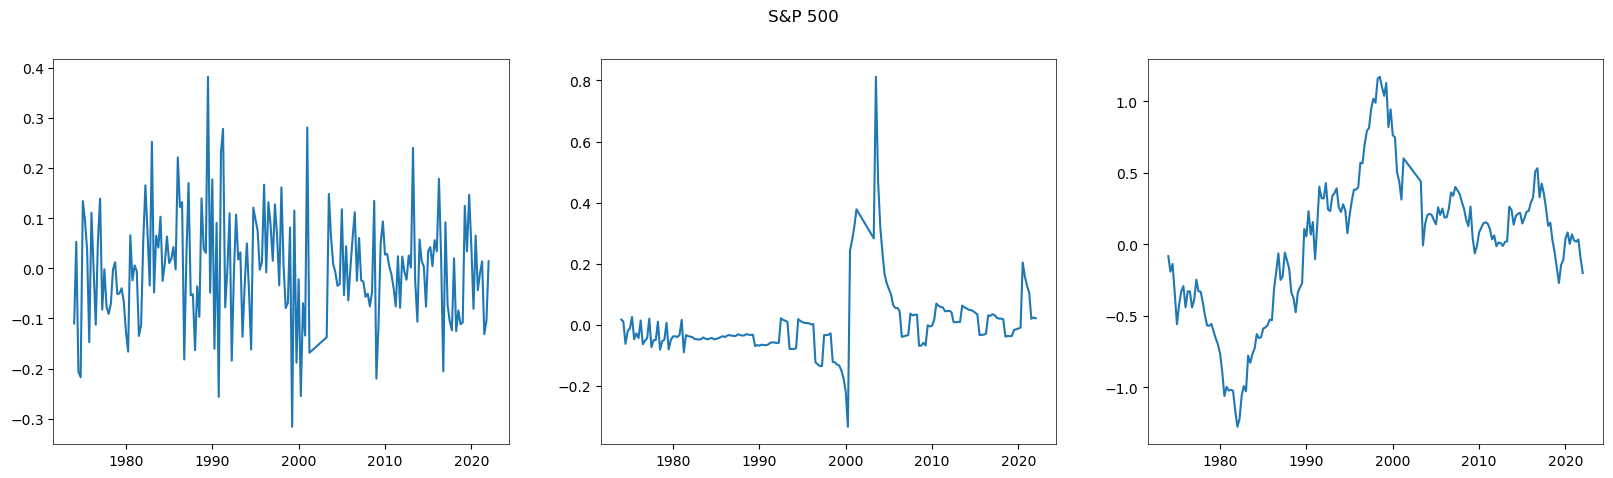

In [343]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('S&P 500')
ax1.plot(C_VAR_v.index,C_VAR_v['ret'])
ax2.plot(C_VAR_v.index,C_VAR_v['ex_roe'])
ax3.plot(C_VAR_v.index,C_VAR_v['alpha'])
plt.show()

In [344]:
grangers_causation_matrix(C_VAR_v, variables = C_VAR_v.columns[[0,2,4]])  

,ret_x,ex_roe_x,alpha_x
ret_y,1.0000,0.0299,0.1213
ex_roe_y,0.0143,1.0000,0.0030
alpha_y,0.0000,0.0010,1.0000


In [345]:
cointegration_test(C_VAR_v.loc[:,C_VAR_v.columns[[0,2,4]]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ret    ::  145.92    > 24.2761   =>   True
ex_roe ::  21.7      > 12.3212   =>   True
alpha  ::  2.46      > 4.1296    =>   False


In [346]:
for name, column in C_VAR_v.loc[:,C_VAR_v.columns[[0,2,4]]].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ret" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.5357
 No. Lags Chosen       = 0
 Critical value 1%     = -3.466
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ex_roe" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.031
 No. Lags Chosen       = 5
 Critical value 1%     = -3.467
 Critical value 5%     = -2.878
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "alpha" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [347]:
model_C_v = VAR(C_VAR_v.iloc[:,:])
x = model_C_v.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-27.87,-27.76,7.885e-13,-27.82
1,-236.3*,-235.6*,2.329e-103*,-236.0*
2,-232.7,-231.3,8.908e-102,-232.1
3,-230.1,-228.1,1.130e-100,-229.3
4,-223.8,-221.1,6.359e-98,-222.7
5,-230.0,-226.6,1.306e-100,-228.6
6,-227.4,-223.4,1.817e-99,-225.8
7,-226.2,-221.5,6.061e-99,-224.3
8,-227.2,-221.9,2.359e-99,-225.0
9,-223.9,-217.9,6.435e-98,-221.5


In [397]:
model_C_v = VAR(C_VAR_v.iloc[:,[0,2,4]])
results_C_v = model_C_v.fit(2)
results_C_v.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Jun, 2022
Time:                     18:05:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -17.3291
Nobs:                     184.000    HQIC:                  -17.5473
Log likelihood:           865.782    FPE:                2.06420e-08
AIC:                     -17.6960    Det(Omega_mle):     1.84546e-08
--------------------------------------------------------------------
Results for equation ret
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000386         0.008136            0.047           0.962
L1.ret           -0.085682         0.075340           -1.137           0.255
L1.ex_roe        -0.026657         0.146763           -0.182           0.856
L

In [398]:
A_C_v=np.linalg.cholesky(results_C_v.resid_acov(0)[0])
H_C_v=np.dot(np.linalg.inv(A_C_v),results_C_v.resid_acov(0)[0])
J=np.zeros((3,6))
J[0][0]=1
J[1][2]=1
J[2][4]=1
coefs_C_v=np.zeros((6,6))
for i in range(3):
    s=0
    for k in range(3):
        for j in range (2):
            coefs_C_v[2*i][s]= results_C_v.coefs[j][i][k]
            s=s+1
coefs_C_v[1][0]=1
coefs_C_v[3][2]=1
coefs_C_v[5][4]=1

In [399]:
e_1=pd.array([1,0,0,0,0,0])
e_2=pd.array([0,0,1,0,0,0])
e_3=pd.array([0,0,0,0,1,0])
e_4=pd.array([-1,0,1,0,1,0])
iden=np.identity(6)
e_etha_1C=np.dot(np.dot(np.dot(np.dot(e_1,etha_C*coefs_C_v),np.linalg.inv(iden-etha_C*coefs_C_v)),J.T),A_sp_v)
e_etha_2C=np.dot(np.dot(np.dot(np.dot(e_2,coefs_C_v),np.linalg.inv(iden-etha_C*coefs_C_v)),J.T),A_sp_v)
e_etha_3C=np.dot(np.dot(np.dot(np.dot(e_3,(etha_C**2)*coefs_C_v),np.linalg.inv(iden-(etha_C)*coefs_C_v)),J.T),A_sp_v)

In [400]:
Vol_C_V=np.dot(e_etha_2C+e_etha_3C-e_etha_1C,(e_etha_2C+e_etha_3C-e_etha_1C).T)
Vol_C_nf_V=np.dot(e_etha_3C,(e_etha_3C).T)
uncond_ratio_C_V=Vol_C_nf_V/Vol_C_V
uncond_ratio_C_V

0.9117162058354118

#### Graphs

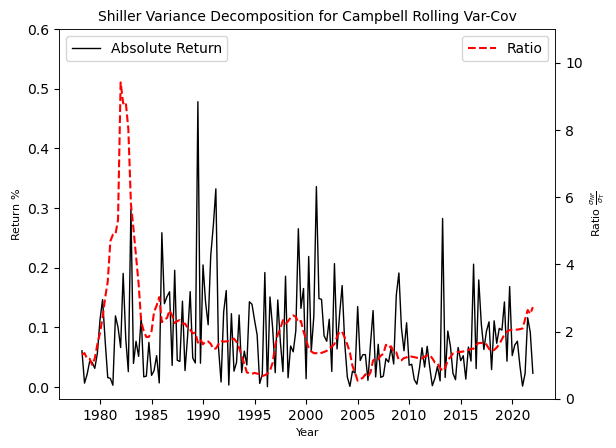

In [493]:
#sns.set_style("whitegrid", {'axes.linewidth':10, 'axes.edgecolor':'black'})
plt.rcParams.update(plt.rcParamsDefault)
import matplotlib
matplotlib.rcParams['axes.linewidth']=0.5
ratio_C_sh['Return']=Campbell.loc[:,'Return']
ratio_C_sh['Return_abs']=np.abs(ratio_C_sh['Return'])
ratio_C_sh.dropna(inplace=True)
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(ratio_C_sh['Return_abs'], color="black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper left')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax.set_ybound(0.6)
ax.set_ylim(-0.02)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(ratio_C_sh['Ratio'],'--',color="red", linewidth=1.5, label= 'Ratio' )
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
ax2.set_ybound(11)
ax2.set_ylim(0.0)
plt.legend()
plt.title('Shiller Variance Decomposition for Campbell Rolling Var-Cov', fontsize=10)
plt.show()

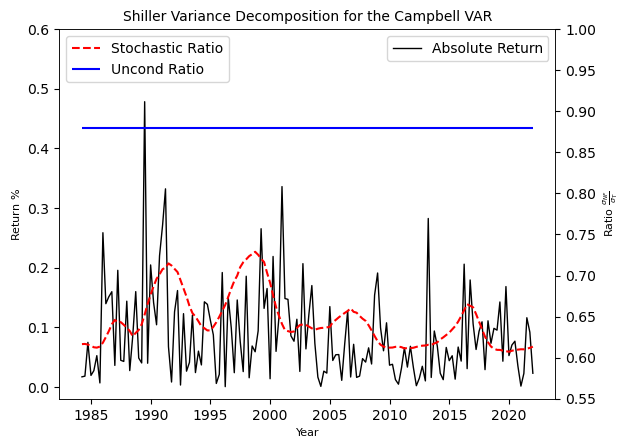

In [492]:
#sns.set_style("whitegrid", {'axes.linewidth':10, 'axes.edgecolor':'black'})
svr_C_sh = pd.read_csv("ratio_c_sh_Sv.csv",index_col=0)
svr_C_sh=svr_C_sh.T
l1=len(svr_C_sh)
l2=len(Campbell['Return'])
C_sv_df = pd.DataFrame((np.abs(Campbell['Return'])).iloc[l2-l1:])
C_sv_df.columns=['Return_abs']
svr_C_sh.index=C_sv_df.index
C_sv_df['Ratio']=svr_C_sh
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(C_sv_df['Return_abs'], color="Black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper right')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
ax.set_ybound(0.6)
ax.set_ylim(-0.02)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(C_sv_df['Ratio'],'--',color="red", linewidth=1.5, label= 'Stochastic Ratio' )
ax2.hlines(uncond_ratio_C,C_sv_df.index[0],C_sv_df.index[-1], linewidth=1.5, label= 'Uncond Ratio' , color="Blue")
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
ax2.legend(loc='upper left')
ax2.set_ybound(1.00)
ax2.set_ylim(0.55)
plt.legend(loc='upper left')
plt.title('Shiller Variance Decomposition for the Campbell VAR', fontsize=10)
plt.show()

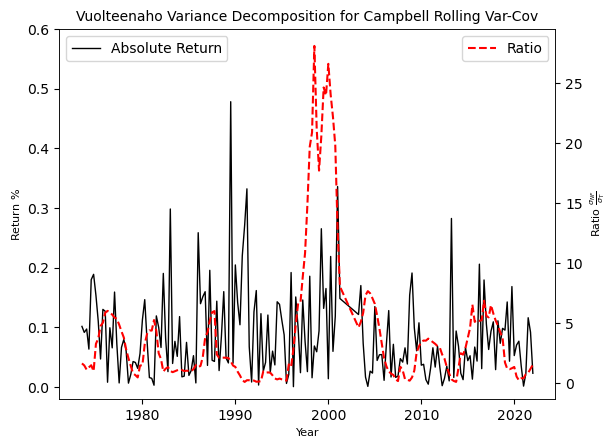

In [494]:
ratio_C_V['Return']=Campbell.loc[:,'Return']
ratio_C_V['Return_abs']=np.abs(ratio_C_V['Return'])
ratio_C_V.dropna(inplace=True)
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(ratio_C_V['Return_abs'], color="black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper left')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax.set_ybound(0.6)
ax.set_ylim(-0.02)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(np.abs(ratio_C_V['Ratio']),'--',color="red", linewidth=1.5, label= 'Ratio' )
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
plt.legend()
plt.title('Vuolteenaho Variance Decomposition for Campbell Rolling Var-Cov', fontsize=10)
plt.show()

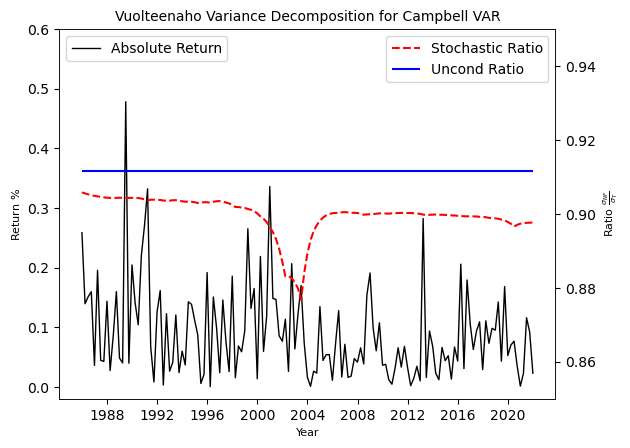

In [496]:
#sns.set_style("whitegrid", {'axes.linewidth':10, 'axes.edgecolor':'black'})
svr_C_vv = pd.read_csv("ratio_c_v_Sv.csv",index_col=0)
svr_C_vv=svr_C_vv.T
l1=len(svr_C_vv)
l2=len(Campbell['Return'])
C_sv_df_v = pd.DataFrame((np.abs(Campbell['Return'])).iloc[l2-l1:])
C_sv_df_v.columns=['Return_abs']
svr_C_vv.index=C_sv_df_v.index
C_sv_df_v['Ratio']=svr_C_vv
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(C_sv_df_v['Return_abs'], color="Black", linewidth=1, label='Absolute Return')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax.set_ybound(0.6)
ax.set_ylim(-0.02)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(C_sv_df_v['Ratio'],'--',color="red", linewidth=1.5, label= 'Stochastic Ratio' )
ax2.hlines(uncond_ratio_C_V,C_sv_df_v.index[0],C_sv_df_v.index[-1], linewidth=1.5, label= 'Uncond Ratio' , color="Blue")
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
ax.legend(loc='upper left')
ax2.set_ybound(0.95)
ax2.set_ylim(0.85)
plt.legend()
plt.title('Vuolteenaho Variance Decomposition for Campbell VAR', fontsize=10)
plt.show()

## Apple Variance Decomposition

#### Variables construction

In [372]:
A_500_Shiller=pd.DataFrame(index=Apple.index)
A_500_Shiller['Log return']=np.log(1+Apple['Return'])
A_500_Shiller['Delta']=np.log(Apple['Dividend'])-np.log(Apple['Price'])
A_500_Shiller['Delta_*']=np.log(Apple['Dividend'])-np.log(Apple['Fundamental Price'])
A_500_Shiller['Delta Dividend']=np.log(Apple['Dividend'])-np.log(Apple['Dividend']).shift(1)
z=np.mean(1+(Apple['Rho']/Apple['Dividend']))
A_500_Shiller['Beta']=np.log(z)+(1/z)*((1+(Apple['Rho']/Apple['Dividend']))-z)

In [373]:
lambda_A = 1/(1+np.exp(np.mean(A_500_Shiller['Beta']+np.log(Apple['Dividend'])-np.log(Apple['Fundamental Price']))))
A_500_Shiller['Delta_*'] = lambda_A*A_500_Shiller['Delta_*']
A_500_Shiller['Beta'] = (1-lambda_A)*A_500_Shiller['Beta']
A_500_Shiller['Delta'] = (1-lambda_A)*A_500_Shiller['Delta'].shift(1)
A_500_Shiller.dropna(inplace=True)
lambda_A

0.26403384784642936

In [374]:
A_500_Vuolteenaho=pd.DataFrame(index=Apple.index)
A_500_Vuolteenaho['Log return']=np.log(1+Apple['Return'])
A_500_Vuolteenaho['Log ROE']=np.log(1+Apple['ROE'])
A_500_Vuolteenaho['Log Rf']=np.log(1+Econ.loc[Apple.index,'Real Interest Rate']/4)
A_500_Vuolteenaho['Log Excess Ret']=A_500_Vuolteenaho['Log return']-A_500_Vuolteenaho['Log Rf']
A_500_Vuolteenaho['Theta']=np.log(Apple['Book Value'])-np.log(Apple['Price'])
A_500_Vuolteenaho['Theta_*']=np.log(Apple['Book Value'])-np.log(Apple['Fundamental Price'])
A_500_Vuolteenaho['Alpha']=np.log(1+(Apple['Rho']/Apple['Fundamental Price']))
A_500_Vuolteenaho['Gamma']=np.log(Apple['Dividend'])-np.log(Apple['Book Value'])
A_500_Vuolteenaho['Delta']=np.log(Apple['Dividend'])-np.log(Apple['Price'])
A_500_Vuolteenaho['Delta_*']=np.log(Apple['Dividend'])-np.log(Apple['Fundamental Price'])

In [375]:
w=0.7
phi_A=w*np.mean(A_500_Vuolteenaho['Gamma'])+(1-w)*np.mean(A_500_Vuolteenaho['Delta'])
etha_A = np.exp(-phi_A)/(1+np.mean(np.exp(-phi_A)))
A_500_Vuolteenaho['Theta_*'] = etha_A*A_500_Vuolteenaho['Theta_*']
A_500_Vuolteenaho['Alpha'] = etha_A*A_500_Vuolteenaho['Alpha']
A_500_Vuolteenaho['Theta'] = A_500_Vuolteenaho['Theta'].shift(1)
A_500_Vuolteenaho.dropna(inplace=True)
etha_A

0.9240273115186116

#### Rolling Variance Covariance Decomposition Apple

In [378]:
varcov_A = A_500_Shiller.rolling(10).cov()

In [377]:
ind = A_500_Shiller.index
ratio_A_sh = pd.DataFrame(index=ind,columns=['Est Var','Est Esp Var','Ratio'])

for i in range(0,len(ind)):
    y=varcov_A.loc[ind[i],:].copy()
    a=y.iloc[1,1]+y.iloc[2,2]+y.iloc[3,3]+y.iloc[4,4]+2*(-y.iloc[1,2]+y.iloc[1,3]+y.iloc[1,4]-y.iloc[2,3]-y.iloc[2,4]+y.iloc[3,4])
    b=y.iloc[4,4]
    #b=2*(y.iloc[1,4]-y.iloc[2,4]+y.iloc[3,4])+y.iloc[4,4]
    ratio_A_sh.iloc[i,0]=a
    ratio_A_sh.iloc[i,1]=b
    ratio_A_sh.iloc[i,2]=b/a

In [379]:
varcov_A_V = A_500_Vuolteenaho.rolling(10).cov()

In [380]:
ind_2 = A_500_Vuolteenaho.index
ratio_A_V = pd.DataFrame(index=ind_2,columns=['Est Var','Est Esp Var','Ratio'])

for i in range(0,len(ind_2)):
    y=varcov_A_V.loc[ind_2[i],:].copy()
    a=y.iloc[1,1]+y.iloc[2,2]+y.iloc[4,4]+y.iloc[5,5]+y.iloc[6,6]+2*(-y.iloc[1,2]-y.iloc[1,5]+y.iloc[1,4]+y.iloc[1,6]+y.iloc[2,5]-y.iloc[2,4]-y.iloc[2,6]-y.iloc[5,4]-y.iloc[5,6]+y.iloc[4,6])
    # b = y.iloc[6,6]
    b =2*(y.iloc[1,6]-y.iloc[2,6]+y.iloc[4,6]-y.iloc[5,6])+y.iloc[6,6]
    ratio_A_V.iloc[i,0]=a
    ratio_A_V.iloc[i,1]=b
    ratio_A_V.iloc[i,2]=b/a

VAR Analysis

In [405]:
A_500_Shiller['Delta_*'] = A_500_Shiller['Delta_*']/lambda_A
A_500_Shiller['Beta'] = A_500_Shiller['Beta']/(1-lambda_A)
A_500_Shiller['Delta'] = A_500_Shiller['Delta']/(1-lambda_A)

In [406]:
A_VAR_sh = pd.DataFrame(index=A_500_Shiller.index, columns=['ret','ret_lag','dd','dd_lag','beta','beta_lag'])
A_VAR_sh['ret'] = A_500_Shiller['Log return']-np.mean(A_500_Shiller['Log return'])
A_VAR_sh['ret_lag'] = A_VAR_sh['ret'].shift(1)
A_VAR_sh['dd'] = (A_500_Shiller['Delta Dividend']-np.mean((A_500_Shiller['Delta Dividend']))).shift(1)
A_VAR_sh['dd_lag'] = A_VAR_sh['dd'].shift(1)
A_VAR_sh['beta'] = (A_500_Shiller['Beta']-np.mean(A_500_Shiller['Beta'])).shift(1)
A_VAR_sh['beta_lag'] = A_VAR_sh['beta'].shift(1)
A_VAR_sh.dropna(inplace=True)
A_VAR_sh.to_csv("A_VAR_sh_input.csv")

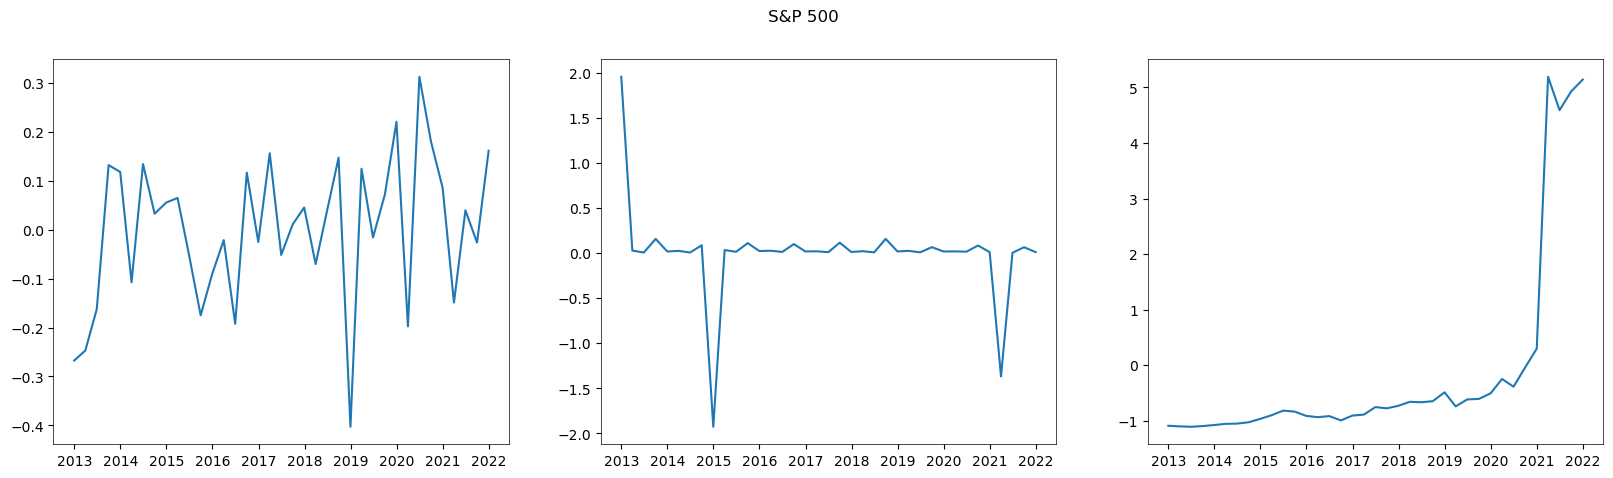

In [407]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('S&P 500')
ax1.plot(A_VAR_sh.index,A_VAR_sh['ret'])
ax2.plot(A_VAR_sh.index,A_VAR_sh['dd'])
ax3.plot(A_VAR_sh.index,A_VAR_sh['beta'])
plt.show()

In [409]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=8
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(A_VAR_sh, variables = A_VAR_sh.columns[[0,2,4]])  

,ret_x,dd_x,beta_x
ret_y,1.0000,0.0935,0.0005
dd_y,0.0555,1.0000,0.3866
beta_y,0.0000,0.6793,1.0000


In [410]:
cointegration_test(A_VAR_sh.loc[:,A_VAR_sh.columns[[0,2,4]]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ret    ::  19.61     > 24.2761   =>   False
dd     ::  8.08      > 12.3212   =>   False
beta   ::  0.28      > 4.1296    =>   False


In [411]:
for name, column in A_VAR_sh.loc[:,A_VAR_sh.columns[[0,2,4]]].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ret" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6349
 No. Lags Chosen       = 0
 Critical value 1%     = -3.627
 Critical value 5%     = -2.946
 Critical value 10%    = -2.612
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dd" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7447
 No. Lags Chosen       = 0
 Critical value 1%     = -3.627
 Critical value 5%     = -2.946
 Critical value 10%    = -2.612
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "beta" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [415]:
model_A = VAR(A_VAR_sh.iloc[:,])
x = model_A.select_order(maxlags=2)
x.summary()

,AIC,BIC,FPE,HQIC
0,-11.16,-10.89,1.430e-05,-11.06
1,-215.5*,-213.6*,2.650e-94*,-214.9*
2,-213.5,-210.0,2.341e-93,-212.3


In [416]:
model_A = VAR(A_VAR_sh.iloc[:,[0,2,4]])
results_A = model_sp.fit(2)
results_A.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Jun, 2022
Time:                     18:10:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -18.0521
Nobs:                     299.000    HQIC:                  -18.2080
Log likelihood:           1485.85    FPE:                1.11485e-08
AIC:                     -18.3120    Det(Omega_mle):     1.04008e-08
--------------------------------------------------------------------
Results for equation ret
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000132         0.004250            0.031           0.975
L1.ret          0.112218         0.058378            1.922           0.055
L1.dd           0.090715         0.223748            0.405           0.685
L1.beta    

In [417]:
A_A_h=np.linalg.cholesky(results_A.resid_acov(0)[0])
H_A_h=np.dot(np.linalg.inv(A_A_h),results_A.resid_acov(0)[0])
J=np.zeros((3,6))
J[0][0]=1
J[1][2]=1
J[2][4]=1
coefs_A_sh=np.zeros((6,6))
for i in range(3):
    s=0
    for k in range(3):
        for j in range (2):
            coefs_A_sh[2*i][s]= results_A.coefs[j][i][k]
            s=s+1
coefs_A_sh[1][0]=1
coefs_A_sh[3][2]=1
coefs_A_sh[5][4]=1

In [418]:
e_1=pd.array([1,0,0,0,0,0])
e_2=pd.array([0,0,1,0,0,0])
e_3=pd.array([0,0,0,0,1,0])
e_4=pd.array([-1,0,1,0,1,0])
iden=np.identity(6)
e_lambda_1A=np.dot(np.dot(np.dot(np.dot(e_1,lambda_A*coefs_A_sh),np.linalg.inv(iden-lambda_A*coefs_A_sh)),J.T),A_A_h)
e_lambda_2A=np.dot(np.dot(np.dot(np.dot(e_2,lambda_A*coefs_A_sh),np.linalg.inv(iden-lambda_A*coefs_A_sh)),J.T),A_A_h)
e_lambda_3A=np.dot(np.dot(np.dot(np.dot(e_3,(1-lambda_A)*lambda_A*coefs_A_sh),np.linalg.inv(iden-lambda_A*coefs_A_sh)),J.T),A_A_h)

In [420]:
Vol_A=np.dot(e_lambda_2A+e_lambda_3A-e_lambda_1A,(e_lambda_2A+e_lambda_3A-e_lambda_1A).T)
Vol_A_nf=np.dot(e_lambda_3A,(e_lambda_3A).T)
uncond_ratio_A=Vol_A_nf/Vol_A
uncond_ratio_A

1.1234946761184632

#### Vuolteenaho VAR decomposition

In [421]:
A_500_Vuolteenaho['Theta_*'] = A_500_Vuolteenaho['Theta_*']/etha_A
A_500_Vuolteenaho['Alpha'] = A_500_Vuolteenaho['Alpha']/etha_A

In [435]:
A_VAR_v = pd.DataFrame(index=A_500_Vuolteenaho.index, columns=['ret','ret_lag','ex_roe','ex_roe_lag','alpha','alpha_lag'])
A_VAR_v['ret'] = A_500_Vuolteenaho['Log return']-np.mean(A_500_Vuolteenaho['Log return'])
A_VAR_v['ret_lag'] = A_VAR_v['ret'].shift(1)
A_VAR_v['ex_roe'] = ((A_500_Vuolteenaho['Log ROE']-A_500_Vuolteenaho['Log Rf'])-np.mean((A_500_Vuolteenaho['Log ROE']-A_500_Vuolteenaho['Log Rf']))).shift(1)
A_VAR_v['ex_roe_lag'] = A_VAR_v['ex_roe'].shift(1)
A_VAR_v['alpha'] = (A_500_Vuolteenaho['Alpha']-np.mean(A_500_Vuolteenaho['Alpha'])).shift(1)
A_VAR_v['alpha_lag'] = A_VAR_v['alpha'].shift(1)
A_VAR_v.dropna(inplace=True)
A_VAR_v.to_csv("A_VAR_v_input.csv")

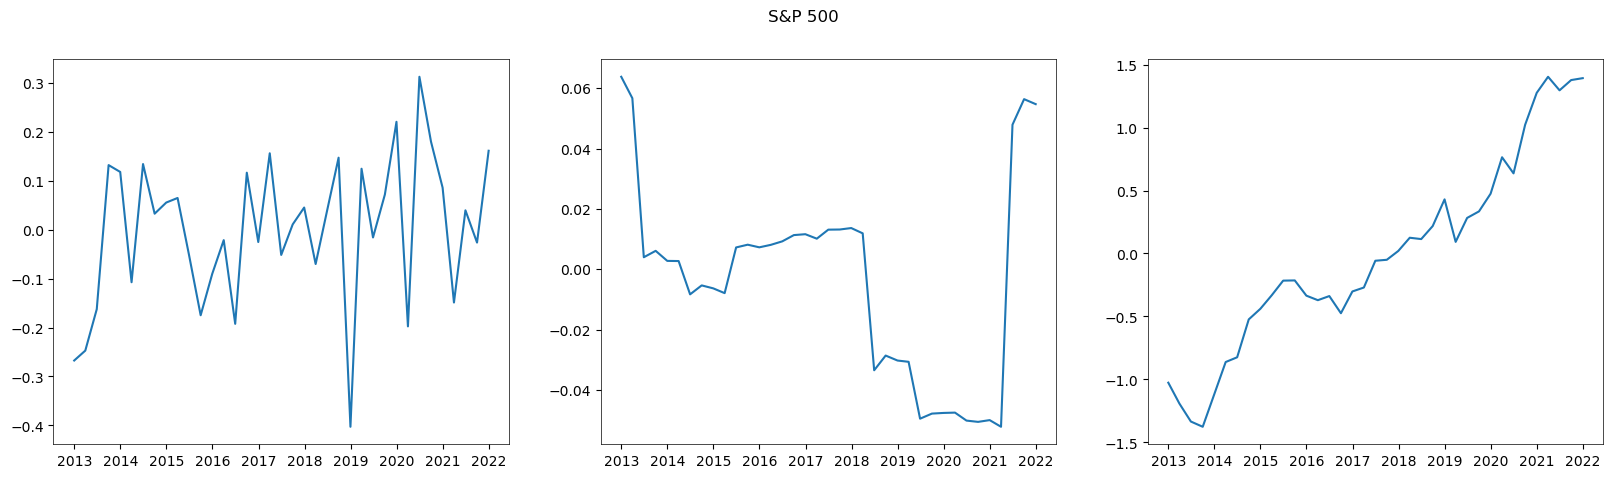

In [423]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('S&P 500')
ax1.plot(A_VAR_v.index,A_VAR_v['ret'])
ax2.plot(A_VAR_v.index,A_VAR_v['ex_roe'])
ax3.plot(A_VAR_v.index,A_VAR_v['alpha'])
plt.show()

In [424]:
grangers_causation_matrix(A_VAR_v, variables = A_VAR_v.columns[[0,2,4]])  

,ret_x,ex_roe_x,alpha_x
ret_y,1.0,0.0000,0.0006
ex_roe_y,0.0,1.0000,0.0019
alpha_y,0.0,0.0054,1.0000


In [425]:
cointegration_test(A_VAR_v.loc[:,A_VAR_v.columns[[0,2,4]]])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ret    ::  38.96     > 24.2761   =>   True
ex_roe ::  17.89     > 12.3212   =>   True
alpha  ::  2.94      > 4.1296    =>   False


In [426]:
for name, column in A_VAR_v.loc[:,A_VAR_v.columns[[0,2,4]]].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ret" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6349
 No. Lags Chosen       = 0
 Critical value 1%     = -3.627
 Critical value 5%     = -2.946
 Critical value 10%    = -2.612
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ex_roe" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1892
 No. Lags Chosen       = 0
 Critical value 1%     = -3.627
 Critical value 5%     = -2.946
 Critical value 10%    = -2.612
 => P-Value = 0.2102. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "alpha" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Si

In [430]:
model_A_v = VAR(A_VAR_v.iloc[:,:])
x = model_A_v.select_order(maxlags=2)
x.summary()

,AIC,BIC,FPE,HQIC
0,-30.88,-30.61,3.878e-14,-30.79
1,-238.7*,-236.9*,2.163e-104*,-238.1*
2,-234.0,-230.6,2.832e-102,-232.9


In [431]:
model_A_v = VAR(A_VAR_v.iloc[:,[0,2,4]])
results_A_v = model_A_v.fit(2)
results_A_v.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Jun, 2022
Time:                     18:16:46
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -17.9531
Nobs:                     35.0000    HQIC:                  -18.5642
Log likelihood:           202.522    FPE:                6.38100e-09
AIC:                     -18.8863    Det(Omega_mle):     3.69271e-09
--------------------------------------------------------------------
Results for equation ret
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.074470         0.078737           -0.946           0.344
L1.ret           -0.245452         0.186666           -1.315           0.189
L1.ex_roe        -1.659843         1.288958           -1.288           0.198
L

In [432]:
A_A_v=np.linalg.cholesky(results_A_v.resid_acov(0)[0])
H_A_v=np.dot(np.linalg.inv(A_A_v),results_A_v.resid_acov(0)[0])
J=np.zeros((3,6))
J[0][0]=1
J[1][2]=1
J[2][4]=1
coefs_A_v=np.zeros((6,6))
for i in range(3):
    s=0
    for k in range(3):
        for j in range (2):
            coefs_A_v[2*i][s]= results_A_v.coefs[j][i][k]
            s=s+1
coefs_A_v[1][0]=1
coefs_A_v[3][2]=1
coefs_A_v[5][4]=1

In [433]:
e_1=pd.array([1,0,0,0,0,0])
e_2=pd.array([0,0,1,0,0,0])
e_3=pd.array([0,0,0,0,1,0])
e_4=pd.array([-1,0,1,0,1,0])
iden=np.identity(6)
e_etha_1A=np.dot(np.dot(np.dot(np.dot(e_1,etha_A*coefs_A_v),np.linalg.inv(iden-etha_A*coefs_A_v)),J.T),A_sp_v)
e_etha_2A=np.dot(np.dot(np.dot(np.dot(e_2,coefs_A_v),np.linalg.inv(iden-etha_A*coefs_A_v)),J.T),A_sp_v)
e_etha_3A=np.dot(np.dot(np.dot(np.dot(e_3,(etha_A**2)*coefs_A_v),np.linalg.inv(iden-etha_A*coefs_A_v)),J.T),A_sp_v)

In [434]:
Vol_A_V=np.dot(e_etha_2A+e_etha_3A-e_etha_1A,(e_etha_2A+e_etha_3A-e_etha_1A).T)
Vol_A_nf_V=np.dot(e_etha_3A,(e_etha_3A).T)
uncond_ratio_A_V=Vol_A_nf_V/Vol_A_V
uncond_ratio_A_V

0.9636359817118486

#### Graphs

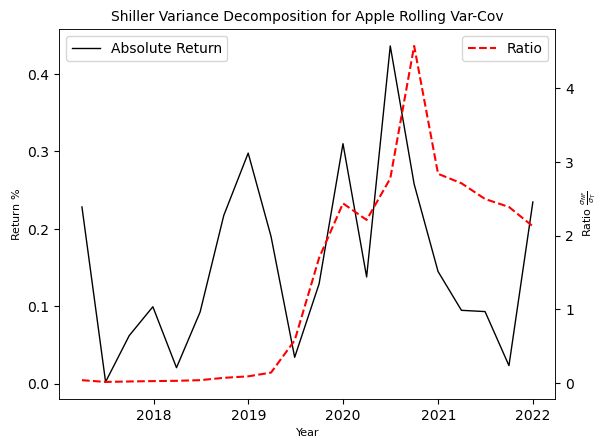

In [438]:
#sns.set_style("whitegrid", {'axes.linewidth':10, 'axes.edgecolor':'black'})
plt.rcParams.update(plt.rcParamsDefault)
import matplotlib
matplotlib.rcParams['axes.linewidth']=0.5
ratio_A_sh['Return']=Apple.loc[:,'Return']
ratio_A_sh['Return_abs']=np.abs(ratio_A_sh['Return'])
ratio_A_sh.dropna(inplace=True)
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(ratio_A_sh['Return_abs'], color="black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper left')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(ratio_A_sh['Ratio'],'--',color="red", linewidth=1.5, label= 'Ratio' )
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
plt.legend()
plt.title('Shiller Variance Decomposition for Apple Rolling Var-Cov', fontsize=10)
plt.show()
#start after 55

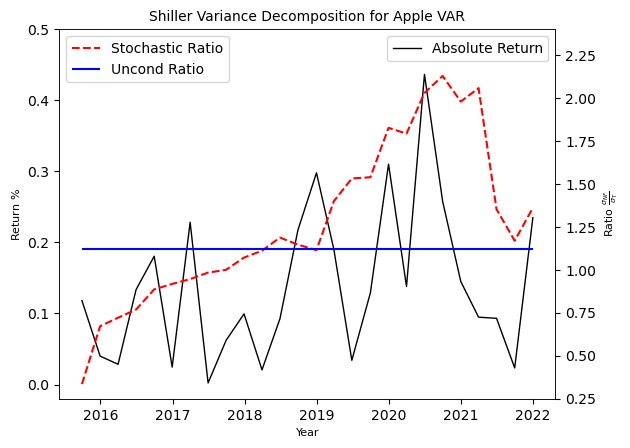

In [501]:
#sns.set_style("whitegrid", {'axes.linewidth':10, 'axes.edgecolor':'black'})
svr_A_sh = pd.read_csv("ratio_A_sh_Sv.csv",index_col=0)
svr_A_sh=svr_A_sh.T
l1=len(svr_A_sh)
l2=len(Apple['Return'])
A_sv_df = pd.DataFrame((np.abs(Apple['Return'])).iloc[l2-l1:])
A_sv_df.columns=['Return_abs']
svr_A_sh.index=A_sv_df.index
A_sv_df['Ratio']=svr_A_sh
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(A_sv_df['Return_abs'], color="Black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper right')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax.set_ybound(0.50)
ax.set_ylim(-0.02)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(A_sv_df['Ratio'],'--',color="red", linewidth=1.5, label= 'Stochastic Ratio' )
ax2.hlines(uncond_ratio_A,A_sv_df.index[0],A_sv_df.index[-1], linewidth=1.5, label= 'Uncond Ratio' , color="Blue")
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
ax2.set_ybound(2.4)
ax2.set_ylim(0.25)
plt.legend()
plt.title('Shiller Variance Decomposition for Apple VAR', fontsize=10)
plt.show()

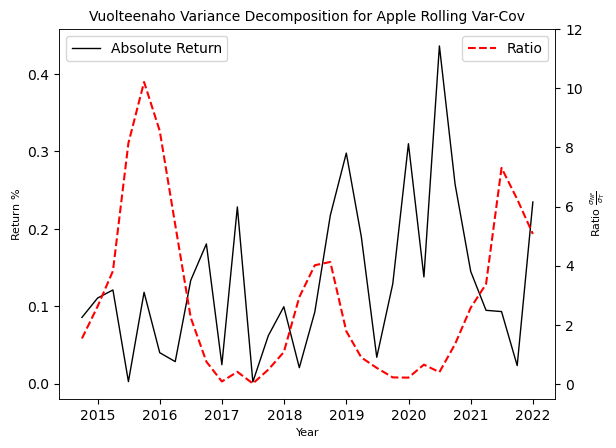

In [505]:
ratio_A_V['Return']=Apple.loc[:,'Return']
ratio_A_V['Return_abs']=np.abs(ratio_A_V['Return'])
ratio_A_V.dropna(inplace=True)
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(ratio_A_V['Return_abs'], color="black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper left')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(np.abs(ratio_A_V['Ratio']),'--',color="red", linewidth=1.5, label= 'Ratio' )
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
ax2.set_ybound(12)
ax2.set_ylim(-0.5)
plt.legend()
plt.title('Vuolteenaho Variance Decomposition for Apple Rolling Var-Cov', fontsize=10)
plt.show()

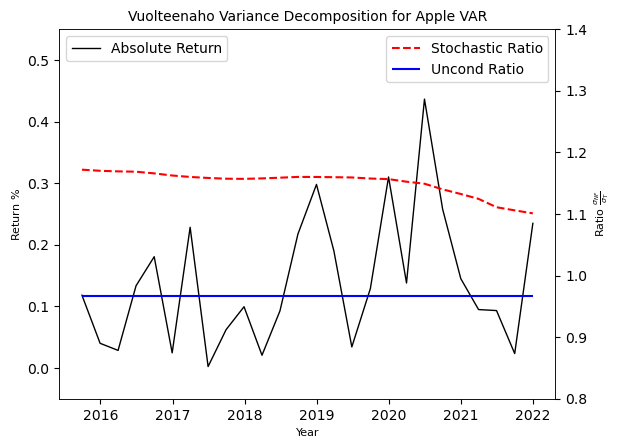

In [511]:
#sns.set_style("whitegrid", {'axes.linewidth':10, 'axes.edgecolor':'black'})
svr_A_vv = pd.read_csv("ratio_A_v_Sv.csv",index_col=0)
svr_A_vv=svr_A_vv.T
l1=len(svr_A_vv)
l2=len(Apple['Return'])
A_sv_df_v = pd.DataFrame((np.abs(Apple['Return'])).iloc[l2-l1:])
A_sv_df_v.columns=['Return_abs']
svr_A_vv.index=A_sv_df_v.index
A_sv_df_v['Ratio']=svr_A_vv
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(A_sv_df_v['Return_abs'], color="Black", linewidth=1, label='Absolute Return')
ax.legend(loc='upper left')
# set x-axis label
ax.set_xlabel("Year",fontsize=8)
# set y-axis label
ax.set_ylabel(ylabel="Return "r'$\%$',color="black",fontsize=8)
# twin object for two different y-axis on the sample plot
ax.set_ybound(0.55)
ax.set_ylim(-0.05)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(A_sv_df_v['Ratio'],'--',color="red", linewidth=1.5, label= 'Stochastic Ratio' )
ax2.hlines(uncond_ratio_SP_V,A_sv_df_v.index[0],A_sv_df_v.index[-1], linewidth=1.5, label= 'Uncond Ratio' , color="Blue")
ax2.set_ylabel(ylabel='Ratio 'r'$\frac{\sigma_{NF}}{\sigma_{T}}$',color="black",fontsize=8)
ax2.set_ybound(1.4)
ax2.set_ylim(0.8)
plt.legend()
plt.title('Vuolteenaho Variance Decomposition for Apple VAR', fontsize=10)
plt.show()